### Setting up Colab and Github 

In [1]:
import os 
from google.colab import drive, files

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome')

Mounted at /content/drive


### Importing Libraries

In [ ]:
!pip install interpret
!pip install bctpy

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier
from interpret import show


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import scipy.stats

import bct
import src.preprocessing.data_loader as dtl
from src.preprocessing.graph_metrics import get_graph_metrics
from math import sqrt
from datetime import date


plt.style.use("ggplot")
%matplotlib inline



### Loading and Transforming Data

In [ ]:
#explain_graph_metrics()

So far implemented graph metrics:
['Degrees', 'Modularity', 'Community Structure', 'Clustering Coefficient', 'Characteristic Path Length', 'Node Betweenness', 'Density', 'Component Vectors', 'Transitivity']
--------------------------------------------------


Which one to explain?	y
selected graph metric not implemented / spelling error
Continue?(y)	g


In [5]:
%%time
train = pd.read_csv("/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/train.csv")
test = pd.read_csv("/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/test.csv")

CPU times: user 28.4 s, sys: 1.13 s, total: 29.5 s
Wall time: 42.9 s


In [6]:
y, X = dtl.preprocess_data(train)
X = X.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
y_test, X_test = dtl.preprocess_data(test)
X_test = X_test.drop(columns = ['MEM_score', 'Apoe'], inplace = False)


### Baseline Model (XGB Untuned Classifier)

In [7]:
%%time
lgb_baseline = lgb.LGBMClassifier(objective="binary")
lgb_baseline.fit(X, y)

CPU times: user 3min 26s, sys: 2.55 s, total: 3min 29s
Wall time: 2min 8s


In [8]:
lgb_baseline.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

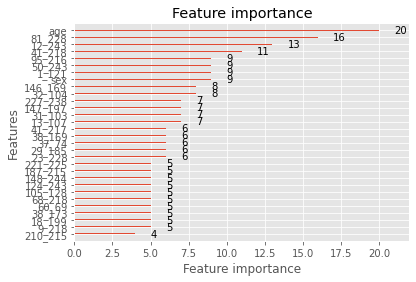

In [11]:
lgb.plot_importance(lgb_baseline, max_num_features=30)

In [14]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_baseline.score(X_test, y_test)), "\n")
pred = lgb_baseline.predict(X_test)
print("Classification Report - LGB Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.765 

Classification Report - LGB Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.77      0.65      0.71        37
         1.0       0.76      0.85      0.80        48

    accuracy                           0.76        85
   macro avg       0.77      0.75      0.75        85
weighted avg       0.77      0.76      0.76        85



In [23]:
explainer = shap.TreeExplainer(lgb_baseline)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [29]:
#visualise a single prediction
shap.initjs() #colab needs this in every cell
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

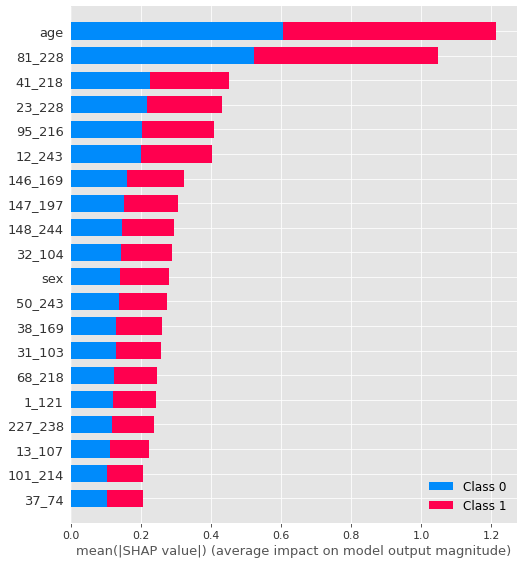

In [25]:
shap.summary_plot(shap_values, X)

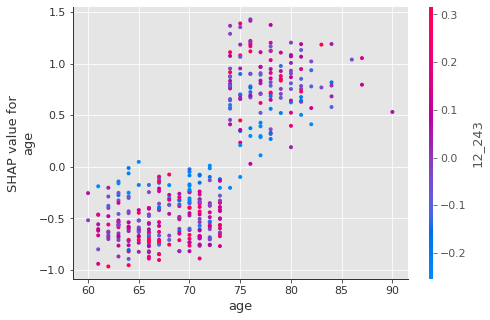

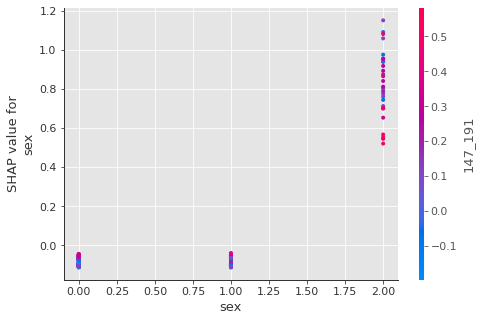

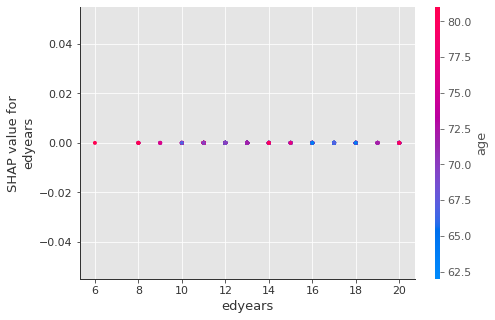

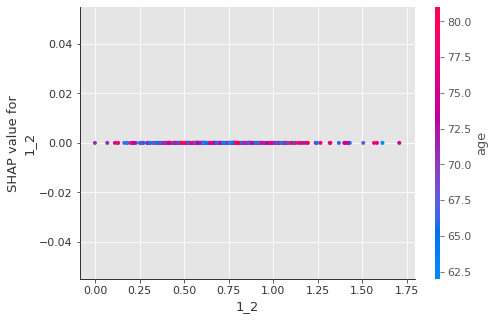

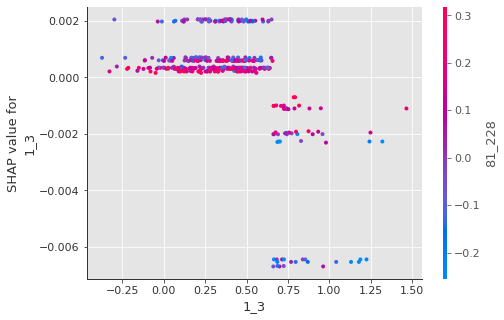

In [27]:
for name in X.columns[:5]:
    shap.dependence_plot(name, shap_values[1], X)#, display_features=X_display)

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:10,:], X.iloc[:10,:])

Output hidden; open in https://colab.research.google.com to view.